In [1]:
from numpy.random.mtrand import shuffle
from qiskit_quantum_knn.qknn import QKNeighborsClassifier
from qiskit_quantum_knn.encoding import analog
from qiskit import aqua
from sklearn import datasets
import qiskit as qk

from qiskit.visualization import plot_histogram
import numpy as np
from dataclasses  import dataclass
from dataset import read_dataset, divide_dataset, balance_dataset
from knn_quantum import QKNN

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Quantum KNN

Equivalents of kNN on quantum have been described in a few papers. The main advantage of quantum kNN is that the distances between the test data point and the all data points of the training set can be calculated in parallel. Another advantage is that finding the k nearest neighbor can be done via a modified version of Grover's algorithm. 

Two main types of quantum kNN have been developped and differs by which metric is used to compute the distance between the data points and which encoding is used:

 * Hamming distance using basis encoding : https://arxiv.org/abs/2103.04253
 * Fidelity using amplitude encoding : https://arxiv.org/pdf/2003.09187.pdf

This note book used the implementation found in :

 * https://github.com/GroenteLepel/qiskit-quantum-knn
 * https://www.ru.nl/publish/pages/913395/daniel_kok_4_maart_2021.pdf
 
This implementation does not use the modified Grover method to find the k nearest neighbor

# Dataset

We use the HTRU2 dataset that can be found at :

 * https://archive.ics.uci.edu/ml/datasets/HTRU2

Let's load the data:

In [2]:
dataset = read_dataset(shuffle=True)
print('Number of points : ', dataset.npts)
print('Number of features :', dataset.features.shape[1])

Number of points :  17898
Number of features : 8


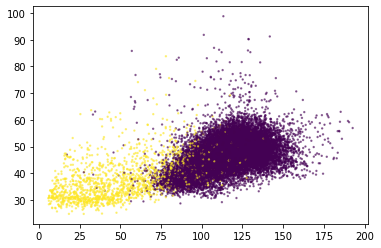

In [3]:
plt.scatter(dataset.features[:,0],dataset.features[:,1],c=dataset.labels,s=2,alpha=0.5)

The data is highly unbalanced which is not a great news. Let's create a balanced version

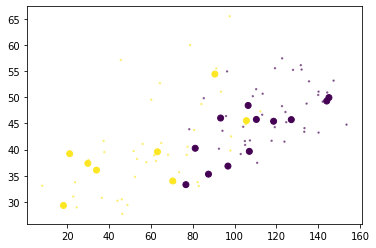

In [4]:
# create a balanced dataset
npts = 100
dataset = balance_dataset(dataset, npts)

# select the feature we want
features=[0,1,2,3]
dataset.features = dataset.features[:,features]

# divide the dataset
train_dataset, test_dataset = divide_dataset(dataset)

# plot the dataset
plt.scatter(train_dataset.features[:,0],train_dataset.features[:,1],c=train_dataset.labels,s=2,alpha=0.5)
plt.scatter(test_dataset.features[:,0],test_dataset.features[:,1],c=test_dataset.labels)

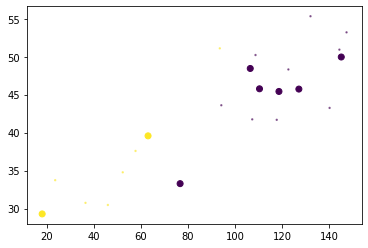

In [5]:
# further reduce the size
ntrain, ntest = 16, 8
train_dataset.features = train_dataset.features[:ntrain]
test_dataset.features = test_dataset.features[:ntest]

train_dataset.labels = train_dataset.labels[:ntrain]
test_dataset.labels = test_dataset.labels[:ntest]

# plot the dataset
plt.scatter(train_dataset.features[:,0],train_dataset.features[:,1],c=train_dataset.labels,s=2,alpha=0.5)
plt.scatter(test_dataset.features[:,0],test_dataset.features[:,1],c=test_dataset.labels)

# Quantum circuit

before explaining the method let's use the library to contrsuct the circuit that will compute the distances.

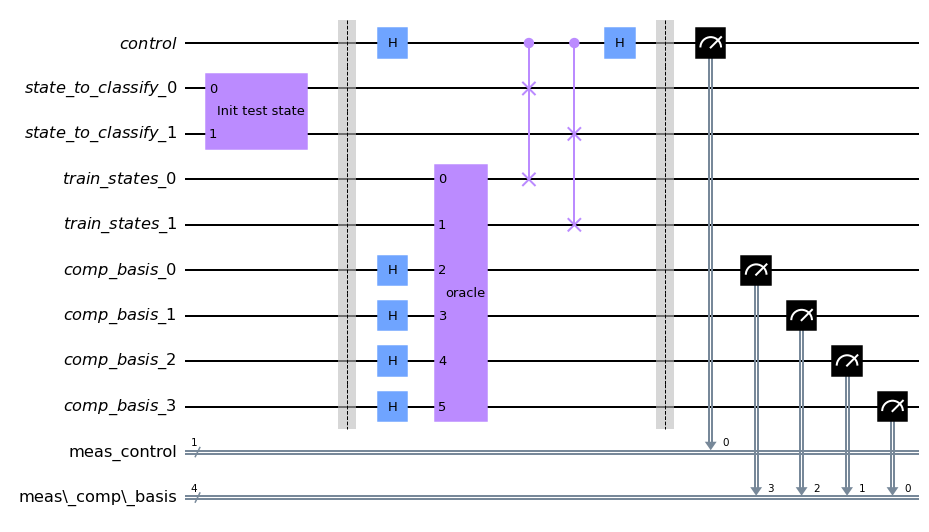

In [6]:
# define the circuit
qknn = QKNN(n_neighbor=3)

# encode the data
qknn.encode_data(train_dataset, test_dataset)

# save some data for convenience
qknn.fit()

# construct the circuits and plot one
circuits = qknn.get_circuits()
circuits[1].draw(output='mpl')

## Encoding the test data

As usual all the qbits start in the $|0\rangle$ state. The first part of the circuit encodes the features of the test data point using an amplitude encoding. With for example 4 features $[x_0, x_1, x_2, x_3]$ the state of the 2 qbits encoding the datapoint (here called state_to_classify_0 and state_to_classify_1) becomes:

$$
x_0|00\rangle + x_1|01\rangle + x_2|10\rangle + x_3 |11\rangle
$$

## Encoding the training dataset

The second part of the circuit is used to encode the training dataset. It uses two registers, one to encode the features (train_states) and one to encode the index of the different training data points (comp_basis). Consequently  the train_states register contains $log_2(n\_features)$ qbits (e.g. 2 qbits for 4 features) and the comp_basis register contains $log2(n\_training\_points)$ qbits (e.g 3 qbits for 16 training points).

The first step is then to compute a complete superposition of all the possible indices using H gates as always. As a reminder having H gates on all qbits of the comp_basis register leads to the creation of the fully superposed state:

$$
\sum_{i=0}^{M}|i\rangle \equiv \frac{1}{\sqrt{M}}(|0000\rangle + |001\rangle + |0010\rangle + ... |1111\rangle)
$$

An Oracle is then used to encode all the training data points as a superposition of states. The action of the oracle is defined as :

$$
W|i\rangle|0\rangle = |i\rangle|V_i\rangle
$$

where $|\phi_i\rangle$ is a amplitude encoded state of the i-th training point. To make it explicit, let's assume that the i-th training state has for features $[v_0^i,v_1^i,v_2^i,v_3^i]$, the Oracle creates the state:

$$
W|i\rangle|0\rangle = |i\rangle(v_0^i|00\rangle + v_1^i|01\rangle + v_2^i|10\rangle + v_3^i|11\rangle)
$$

Since the Oracle act here on a superposition of the states the state of the two register after the orcale is given by:

$$
\sum_{i=1}^{M} |i\rangle(v_0^i|00\rangle + v_1^i|01\rangle + v_2^i|10\rangle + v_3^i|11\rangle)
$$

## Compute the Fildelity

The third part of the circuit is a SWAP test between the register holding the test data point and the one containing the training set. The state of the system is transformed as :

$$
\sum_i |i\rangle|V_i\rangle|X\rangle|0\rangle \rightarrow \sum_i |i\rangle|V_i\rangle|X\rangle\frac{|0\rangle +|1\rangle}{\sqrt{2}}
$$

$$
\sum_i |i\rangle|V_i\rangle|X\rangle\frac{|0\rangle +|1\rangle}{\sqrt{2}} \rightarrow \sum_i |i\rangle|V_i\rangle|X\rangle\frac{|0\rangle}{\sqrt{2}} + \sum_i |i\rangle|X\rangle|V_i\rangle\frac{|1\rangle}{\sqrt{2}}
$$

$$
\sum_i |i\rangle|V_i\rangle|X\rangle\frac{|0\rangle}{\sqrt{2}} + \sum_i  |i\rangle|X\rangle|V_i\rangle\frac{|1\rangle}{\sqrt{2}}\rightarrow
\sum_i |i\rangle|V_i\rangle|X\rangle\frac{|0\rangle+|1\rangle}{2} + \sum_i|i\rangle|X\rangle|V_i\rangle\frac{|0\rangle - |1\rangle}{2}
$$


Rearragning all the terms leads to :

$$
\rightarrow \frac{1}{2} \sum_i |i\rangle(|V_i\rangle|X\rangle + |X\rangle|V_i\rangle) |0\rangle + \sum_i |i\rangle(|V_i\rangle|X\rangle - |X\rangle|V_i\rangle) |1\rangle
$$

The probablity to measure $|i\rangle|0\rangle$ and $|i\rangle|1\rangle$  are therefore

$$
P(i,0) = \frac{1}{2}+\frac{1}{2}||\langle V_i|X\rangle ||^2
$$
$$
P(i,1) = \frac{1}{2}-\frac{1}{2}||\langle V_i|X\rangle ||^2
$$


# Testing the circuit

In [7]:
prediction = qknn.test()
print(qknn.test_labels)
print(prediction)

 ==> Classification succesfull at 62.500000 percent
[1. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0. 0. 0.]


# Visualize the result

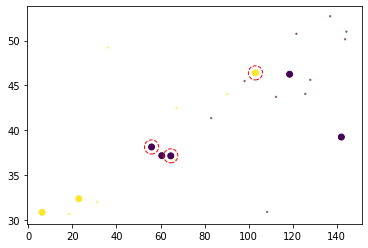

In [25]:
# plot the dataset
plt.scatter(train_dataset.features[:,0],train_dataset.features[:,1],c=train_dataset.labels,s=2,alpha=0.5)
plt.scatter(test_dataset.features[:,0],test_dataset.features[:,1],c=prediction)
for x,y,yp in zip(test_dataset.features,test_dataset.labels,prediction):
    if y!=yp:
        plt.scatter(x[0],x[1], facecolors="none", edgecolors='r', linewidth=1, linestyle='--', s=200)